# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/ERA V1/Assignment 10/src'

Mounted at /content/drive
/content/drive/My Drive/ERA V1/Assignment 10/src


In [2]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
 

In [3]:
!pip install torch-lr-finder

In [4]:
pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 14.1 MB/s eta 0:00:00


In [18]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=770d7519eb09f11bbe3a63b8e3bd9f5c0fb25aed42ff448f74127d441d525e8e
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [5]:
from __future__ import print_function
from pytorch_lightning import LightningModule, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transform import *
from model import *
from utils import *
from dataset import cifar10Dataset, get_loader
from train import *
from test import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy

In [6]:
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
AVAIL_GPUS

1

In [8]:
class cifar10Dataset(torchvision.datasets.CIFAR10):
  """"
  Custom Dataset class
  """

  def __init__(self, root = "./data", train = True, transform = None, download = True):
    super().__init__(root=root, train=train, transform=transform, download=download)
    self.transform = transform

  def __getitem__(self, index):

    img, target = self.data[index], self.targets[index]

    if self.transform is not None:
      img = self.transform(image=img)["image"]
    return (img, target)

In [87]:
class LitNet(LightningModule):
  def __init__(self, max_lr):
    super().__init__()

    self.dropout = 0.1
    self.max_lr = max_lr
    self.max_epochs = 25

    self.criterion = nn.CrossEntropyLoss()
    self.accuracy = Accuracy(task='multiclass',num_classes=10)

    self.means = (0.4914, 0.4822, 0.4465)
    self.stds = (0.2470, 0.2435, 0.2616)

    self.train_transform =  A.Compose([
        A.Normalize(self.means, self.stds),
        A.PadIfNeeded(36,36),
        A.RandomCrop(height=32, width=32),
        A.HorizontalFlip(p=0.05),
        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8, fill_value=self.means, mask_fill_value =None),
        ToTensorV2()])

    self.test_transform = A.Compose([
        A.Normalize(self.means, self.stds),
        ToTensorV2()])


    # Prep Layer input 32/1/1
    self.preplayer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    ) # output_size =32

    # Layer 1
    self.convlayer1 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(128),
        nn.ReLU()

    ) # output_size = 32

    self.res1 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU()
        ) # output_size = 16

    # Layer 2
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(256),
        nn.ReLU()
    ) # output_size = 16

    # Layer 3
    self.convlayer2 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(512),
        nn.ReLU()

    ) # output_size = 8

    self.res2 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()
        ) # output_size = 8

    # MAx Pooling with Kernel Size 4
    self.maxpool =  nn.MaxPool2d(4, 2)


    # fully connected layer
    self.fc = nn.Linear(512, 10)

  def forward(self, x):
    x = self.preplayer(x)
    x = self.convlayer1(x)
    r1 = self.res1(x)
    x = x + r1
    x = self.layer2(x)
    x = self.convlayer2(x)
    r2 = self.res2(x)
    x = x + r2
    x = self.maxpool(x)
    x = self.fc(torch.squeeze(x))
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)


  def training_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = self.criterion(logits, y)
      return loss

  def validation_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = self.criterion(logits, y)
      preds = torch.argmax(logits, dim=1)
      self.accuracy(preds, y)

      # Calling self.log will surface up scalars for you in TensorBoard
      self.log("val_loss", loss, prog_bar=True)
      self.log("val_acc", self.accuracy, prog_bar=True)
      return loss

  def test_step(self, batch, batch_idx):
      # Here we just reuse the validation_step for testing
      return self.validation_step(batch, batch_idx)

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=0.03, weight_decay=1e-4)
      scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, steps_per_epoch=BATCH_SIZE, epochs=self.max_epochs, pct_start=5/self.max_epochs, div_factor=100,
                                                      three_phase=False,final_div_factor=100,anneal_strategy='linear')

      return {
          'optimizer':optimizer,
          'lr_scheduler':{
          'scheduler': scheduler,
          'interval': 'step'
      }}

  #####################################
  ## DATA RELATED
  #####################################

  def prepare_data(self):
      # download
      cifar10Dataset(root = "./data", train=True, download=True)
      cifar10Dataset(root = "./data", train=False, download=True)

  def setup(self, stage=None):


      # Assign train/val datasets for use in dataloaders
      if stage == "fit" or stage is None:
          self.full_data = cifar10Dataset(root = "./data", train=True, transform=self.train_transform)
          self.train_data, self.val_data = random_split(self.full_data, [45000, 5000])

      # Assign test dataset for use in dataloader(s)
      if stage == "test" or stage is None:
          self.test_data = cifar10Dataset(root = "./data", train=False, transform=self.test_transform)

  def train_dataloader(self):
      return DataLoader(self.train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

  def val_dataloader(self):
      return DataLoader(self.val_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

  def test_dataloader(self):
      return DataLoader(self.test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.87E-02


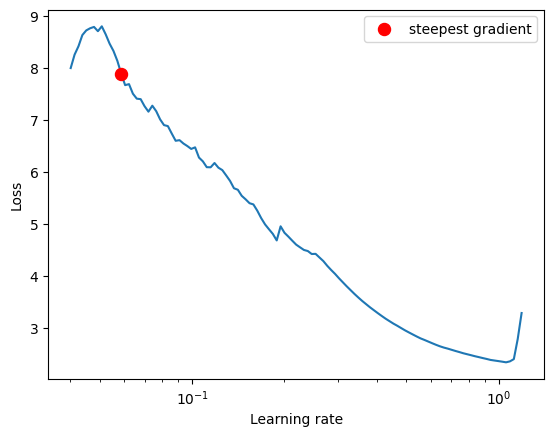

In [10]:
from torch_lr_finder import LRFinder
model = LitNet(0.1)
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

train_set = cifar10Dataset(root = "./data", train=True, transform=model.train_transform)
# train dataloader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

lr_finder2 = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder2.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder2.plot()
lr_finder2.reset()

In [12]:
# train_set = cifar10Dataset(root = "./data", train=True, transform=model.train_transform)
# # train dataloader
# train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

model = LitNet(5.87E-02)
trainer = Trainer(
    precision = 16,
    # gpus = AVAIL_GPUS,
    max_epochs = 20,
)
trainer.fit(model)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | criterion  | CrossEntropyLoss   | 0     
1 | accuracy   | MulticlassAccuracy | 0     
2 | preplayer  | Sequential         | 1.9 K 
3 | convlayer1 | Sequential         | 74.0 K
4 | res1       | Sequential         | 295 K 
5 | layer2     | Sequential         | 295 K 
6 | convlayer2 | Sequential         | 1.2 M 
7 | res2       | Sequential         | 4.7 M 
8 | maxpool    | MaxPool2d          | 0     
9 | fc         | Linear             | 5.1 K 
--------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.293    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [13]:
trainer.test()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/ERA V1/Assignment 10/src/lightning_logs/version_10/checkpoints/epoch=19-step=3520.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/ERA V1/Assignment 10/src/lightning_logs/version_10/checkpoints/epoch=19-step=3520.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.695900022983551
        val_loss             0.890817403793335
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.890817403793335, 'val_acc': 0.695900022983551}]

In [25]:
trainer.save_checkpoint('model.pth')

In [14]:
import gradio as gr

In [15]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available? True


In [16]:
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

In [20]:
classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [47]:
def mis_classified_images(model, device, test_loader):
  incorrect_examples = []
  incorrect_labels = []
  incorrect_pred = []
  model.eval()
  for data,target in test_loader:

    data , target = data.to(device), target.to(device)
    output = model(data) # shape = torch.Size([batch_size, 10])
    pred = output.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
    if idxs_mask.numel(): #if index masks is non-empty append the correspoding data value in incorrect examples
      incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy()) #
      incorrect_labels.append(target[idxs_mask].cpu().numpy())# #the corresponding target to the misclassified image
      incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy()) ##the corresponiding predicted class of the misclassified image

  return incorrect_examples, incorrect_labels,incorrect_pred

In [24]:
test_loader = DataLoader(model.test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)
# incorrect_examples, incorrect_labels,incorrect_pred = mis_classified_images(model, device, test_loader)

In [67]:
data, taget = next(iter(test_loader))

In [68]:
data[0].shape

torch.Size([3, 32, 32])

In [88]:
model = LitNet(5.87E-02)

In [106]:
def trial(input_img, transparency):
    # transform = model.test_transform
    transform = transforms.ToTensor()
    org_img = input_img
    # input_img = transform(input_img)["image"]
    input_img = input_img.to(device)
    input_img = input_img.unsqueeze(0)
    print(input_img.shape)
    outputs = model(input_img)
    prediction = outputs.argmax(dim=1, keepdim=True)
    target_layers = [model.res2[-2]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_img, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)
    return classes[prediction[0].item()], visualization

In [109]:
class1, vis = trial(data[1], 0.9)

torch.Size([1, 3, 32, 32])
No problem here
tensor([[-2.2931, -2.3106, -2.3263, -2.2899, -2.2758, -2.2716, -2.2806, -2.4184,
         -2.3497, -2.2223]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 10])
No problem here


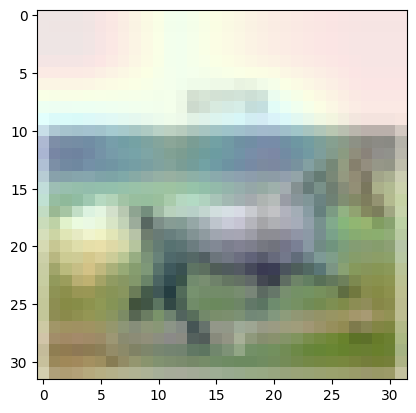

In [110]:
import matplotlib.pyplot as plt
plt.imshow(vis)

In [114]:
def inference(input_img, transparency):
    transform = transforms.ToTensor()
    org_img = input_img
    input_img = transform(input_img)
    input_img = input_img.to(device)
    input_img = input_img.unsqueeze(0)
    outputs = model(input_img)
    _, prediction = torch.max(outputs, 1)
    target_layers = [model.res2[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_img, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0)#.to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    visualization = show_cam_on_image(org_img/255, grayscale_cam, use_rgb=True, image_weight=transparency)
    return classes[prediction[0].item()], visualization

demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])
demo.launch()

<ipython-input-114-3348c5f4c278>:20: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>